## Import

In [69]:
from ultralytics import YOLO
import torch
import os
from PIL import Image
import torch.nn as nn
import timm
from torchvision import transforms, models
import numpy as np
import matplotlib.pyplot as plt
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
ROOT_DIR_KARACHI = fr"C:\Users\Mohtashim Butt\Documents\SPROJ-Fixing\spatial\Karachi"
IMG_SZ = 256

## Metrices Helpers

In [59]:
# Define helper functions for calculating metrics as provided
def calculate_pixel_error(pred, target):
    """
    Calculate the Pixel-wise Error.
    """
    return np.not_equal(pred, target).sum() / pred.size

def calculate_metrics(pred, target, epsilon=1e-6):
    """
    Calculate Precision, Recall, F1-score, and Accuracy.
    """
    pred = torch.tensor(pred)
    target = torch.tensor(target)
    tp = torch.sum((pred == 1) & (target == 1)).float()
    tn = torch.sum((pred == 0) & (target == 0)).float()
    fp = torch.sum((pred == 1) & (target == 0)).float()
    fn = torch.sum((pred == 0) & (target == 1)).float()

    precision = tp / (tp + fp + epsilon)
    recall = tp / (tp + fn + epsilon)
    f1_score = 2 * (precision * recall) / (precision + recall + epsilon)
    accuracy = (tp + tn) / (tp + tn + fp + fn + epsilon)

    return precision.item(), recall.item(), f1_score.item(), accuracy.item()

def calculate_dice_loss(pred, target, epsilon=1e-6):
    """
    Calculate the Dice Loss.
    """
    pred = torch.tensor(pred).float()
    target = torch.tensor(target).float()
    intersection = torch.sum(pred * target)
    dice_coeff = (2 * intersection + epsilon) / (torch.sum(pred) + torch.sum(target) + epsilon)
    dice_loss = 1 - dice_coeff
    return dice_loss.item()

def calculate_iou(pred, target, epsilon=1e-6):
    """
    Calculate the Intersection over Union (IoU).
    """
    pred = torch.tensor(pred).float()
    target = torch.tensor(target).float()
    intersection = torch.sum(pred * target)
    union = torch.sum(pred) + torch.sum(target) - intersection
    iou = (intersection + epsilon) / (union + epsilon)
    return iou.item()

# Define function to load image and convert it to a binary mask
def load_image_as_mask(image_path):
    image = Image.open(image_path).convert('L')
    mask = np.array(image) > 127  # Assuming binary mask with thresholding
    return mask.astype(np.uint8)  # Convert to 0 and 1

# Modified dump_all_metrics function
def dump_all_metrics(ground_truth_folder, inference_folder, num_samples=5):
    ground_truth_files = sorted(os.listdir(ground_truth_folder))
    inference_files = sorted(os.listdir(inference_folder))

    # Ensuring the same number of ground truth and inference files
    assert len(ground_truth_files) == len(inference_files), "Mismatch in the number of ground truth and inference images."

    # Select random samples if specified
    samples = np.random.choice(len(ground_truth_files), num_samples, replace=False)

    # Initialize lists to store metrics
    all_pixel_errors, precisions, recalls, f1_scores, accuracies, dice_losses, ious = [], [], [], [], [], [], []

    # Iterate over samples and calculate metrics
    for idx in samples:
        ground_truth_path = os.path.join(ground_truth_folder, ground_truth_files[idx])
        inference_path = os.path.join(inference_folder, inference_files[idx])

        # Load masks
        ground_truth_mask = load_image_as_mask(ground_truth_path)
        pred_mask = load_image_as_mask(inference_path)

        # Calculate metrics for current sample
        pixel_error = calculate_pixel_error(pred_mask, ground_truth_mask)
        precision, recall, f1_score, accuracy = calculate_metrics(pred_mask, ground_truth_mask)
        dice_loss = calculate_dice_loss(pred_mask, ground_truth_mask)
        iou = calculate_iou(pred_mask, ground_truth_mask)

        # Append each metric to lists for averaging later
        all_pixel_errors.append(pixel_error)
        precisions.append(precision)
        recalls.append(recall)
        f1_scores.append(f1_score)
        accuracies.append(accuracy)
        dice_losses.append(dice_loss)
        ious.append(iou)

    # Calculate average metrics across all samples
    avg_pixel_error = np.mean(all_pixel_errors)
    avg_precision = np.mean(precisions)
    avg_recall = np.mean(recalls)
    avg_f1_score = np.mean(f1_scores)
    avg_accuracy = np.mean(accuracies)
    avg_dice_loss = np.mean(dice_losses)
    avg_iou = np.mean(ious)

    # Print average metrics
    print("Average Pixel-wise Error:", avg_pixel_error)
    print("Average Precision:", avg_precision)
    print("Average Recall:", avg_recall)
    print("Average F1 Score:", avg_f1_score)
    print("Average Accuracy:", avg_accuracy)
    print("Average Dice Loss:", avg_dice_loss)
    print("Average IoU:", avg_iou)

## Inference Helper

In [66]:
# def inference(model, images_folder, output_folder, model_type='HRNet'):
#     # Create the output folder if it doesn't exist
#     os.makedirs(output_folder, exist_ok=True)

#     # Define preprocessing for HRNet
#     preprocess = transforms.Compose([
#         transforms.Resize((IMG_SZ, IMG_SZ)),  # Resize to match input size of the model
#         transforms.ToTensor(),
#     ])

#     # Process each image in the images folder
#     for image_file in os.listdir(images_folder):
#         # Full path of the image
#         image_path = os.path.join(images_folder, image_file)
        
#         # Check if it's a valid image file
#         if os.path.isfile(image_path) and image_file.lower().endswith(('.png', '.jpg', '.jpeg')):
            
#             if model_type == 'Yolov11':
#                 # For Yolov11
#                 results = model.predict(source=image_path, conf=0.0)
#                 # Check if there are any masks in the results
#                 if results[0].masks is None:
#                     final_mask = torch.zeros(1, IMG_SZ, IMG_SZ)
#                 else:
#                     # Stack all masks for the image and create a final binary mask
#                     masks = results[0].masks.data
#                     final_mask = torch.any(masks, dim=0, keepdim=True).float()
            
#             elif model_type == 'HRNet':
#                 # For HRNet
#                 image = Image.open(image_path).convert("RGB")
#                 image_tensor = preprocess(image).unsqueeze(0).to(device)  # Preprocess and add batch dimension
#                 with torch.no_grad():
#                     output = model(image_tensor)
#                     pred_mask = (output > 0.5).float().squeeze(0)  # Apply thresholding to obtain binary mask
#                     final_mask = pred_mask.cpu()
            
#             # Convert the final mask to a binary image (0, 255)
#             binary_mask = (final_mask.squeeze().numpy() * 255).astype('uint8')
#             binary_mask_img = Image.fromarray(binary_mask)

#             # Save the mask with the same name as the original image but in the output folder
#             mask_file_name = os.path.splitext(image_file)[0] + '_mask.png'
#             mask_file_path = os.path.join(output_folder, mask_file_name)
#             binary_mask_img.save(mask_file_path)

#             print(f"Model mask saved for image {image_file} at {mask_file_path}")

def inference(model, images_folder, output_folder, model_type):
    print("INFERENCE FOR: ", model_type)
    # Create the output folder if it doesn't exist
    os.makedirs(output_folder, exist_ok=True)

    # Define preprocessing for the images
    preprocess = transforms.Compose([
        transforms.Resize((IMG_SZ, IMG_SZ)),  # Resize to match input size of the model
        transforms.ToTensor(),
    ])

    # Set the model to evaluation mode
    model.eval()

    # Process each image in the images folder
    for image_file in os.listdir(images_folder):
        # Full path of the image
        image_path = os.path.join(images_folder, image_file)
        
        # Check if it's a valid image file
        if os.path.isfile(image_path) and image_file.lower().endswith(('.png', '.jpg', '.jpeg')):
            
            # Load and preprocess the image
            image = Image.open(image_path).convert("RGB")
            image_tensor = preprocess(image).unsqueeze(0).to(device)  # Preprocess and add batch dimension

            # Perform inference based on model type
            with torch.no_grad():
                if model_type == 'Yolov11':
                    # For Yolov11
                    results = model.predict(source=image_path, conf=0.0)
                    if results[0].masks is None:
                        final_mask = torch.zeros(1, IMG_SZ, IMG_SZ)
                    else:
                        masks = results[0].masks.data
                        final_mask = torch.any(masks, dim=0, keepdim=True).float()

                elif model_type == 'HRNet':
                    # For HRNet
                    output = model(image_tensor)
                    pred_mask = (output > 0.5).float().squeeze(0)
                    final_mask = pred_mask.cpu()

                elif model_type == 'DeepLabv3+':
                    # For DeepLabv3
                    output = model(image_tensor)['out']  # Access 'out' key for DeepLabv3 output
                    pred_mask = (output > 0.5).float().squeeze(0)
                    final_mask = pred_mask.cpu()

            # Convert the final mask to a binary image (0, 255)
            binary_mask = (final_mask.squeeze().numpy() * 255).astype('uint8')
            binary_mask_img = Image.fromarray(binary_mask)

            # Save the mask with the same name as the original image but in the output folder
            mask_file_name = os.path.splitext(image_file)[0] + '_mask.png'
            mask_file_path = os.path.join(output_folder, mask_file_name)
            binary_mask_img.save(mask_file_path)

            print(f"Model mask saved for image {image_file} at {mask_file_path}")

## Karachi Loader

In [38]:
# karachi_dataset = PreloadedDataset(root_dir=ROOT_DIR_KARACHI, further_path='images', transform=transform)
# karachi_loader = DataLoader(karachi_dataset, batch_size=1, shuffle=False)

# YOLOv11

In [47]:

model = YOLO(fr"C:\Users\Mohtashim Butt\Documents\SPROJ-Fixing\Yolo\best_nano.pt")

In [49]:
# Get inference
images_folder = r'Karachi_new\images'
output_folder = r'Yolov11'
inference(model=model, images_folder=images_folder, output_folder=output_folder, model_type=output_folder)

# Get Metrices
ground_truth_folder = fr"Karachi_new\masks"
inference_folder = fr"Yolov11"
dump_all_metrics(ground_truth_folder, inference_folder)


image 1/1 c:\Users\Mohtashim Butt\Documents\SPROJ-Fixing\spatial\Karachi_new\images\ges_359835_298410_20_jpg.rf.d4afd8e44d5832a2077b6e76ccd65000.jpg: 256x256 300 GreenSpaces, 98.3ms
Speed: 0.0ms preprocess, 98.3ms inference, 300.7ms postprocess per image at shape (1, 3, 256, 256)
Model mask saved for image ges_359835_298410_20_jpg.rf.d4afd8e44d5832a2077b6e76ccd65000.jpg at Yolov11\ges_359835_298410_20_jpg.rf.d4afd8e44d5832a2077b6e76ccd65000_mask.png

image 1/1 c:\Users\Mohtashim Butt\Documents\SPROJ-Fixing\spatial\Karachi_new\images\ges_359836_298410_20_jpg.rf.7cc7ead7c69d4af24fa6f6ee35c0187e.jpg: 256x256 300 GreenSpaces, 84.9ms
Speed: 0.0ms preprocess, 84.9ms inference, 261.8ms postprocess per image at shape (1, 3, 256, 256)
Model mask saved for image ges_359836_298410_20_jpg.rf.7cc7ead7c69d4af24fa6f6ee35c0187e.jpg at Yolov11\ges_359836_298410_20_jpg.rf.7cc7ead7c69d4af24fa6f6ee35c0187e_mask.png

image 1/1 c:\Users\Mohtashim Butt\Documents\SPROJ-Fixing\spatial\Karachi_new\images\ges_3

## HRNET

In [50]:
class HRNetForSegmentation(nn.Module):
    def __init__(self, num_classes, dropout_prob=0.3):
        super(HRNetForSegmentation, self).__init__()
        self.backbone = timm.create_model('hrnet_w18', pretrained=True, features_only=True)
        self.segmentation_head = nn.Sequential(
            nn.Conv2d(1024, 1, kernel_size=(1, 1), stride=(1, 1)),
            nn.Sigmoid()
        )
        self.upsample = nn.Upsample(size=(IMG_SZ, IMG_SZ), mode='bilinear', align_corners=False)
    
    def forward(self, x):
        features = self.backbone(x)
        x = features[-1]
        x = self.segmentation_head(x)
        x = self.upsample(x)  # Ensure output size matches target size
        return x
    
model = HRNetForSegmentation(num_classes=1)  # 1 class for binary segmentation
model.load_state_dict(torch.load(fr"C:\Users\Mohtashim Butt\Documents\SPROJ-Fixing\HRNet\best_model.pth"))
model = model.to(device)

Unexpected keys (downsamp_modules.0.0.bias, downsamp_modules.0.0.weight, downsamp_modules.0.1.bias, downsamp_modules.0.1.num_batches_tracked, downsamp_modules.0.1.running_mean, downsamp_modules.0.1.running_var, downsamp_modules.0.1.weight, downsamp_modules.1.0.bias, downsamp_modules.1.0.weight, downsamp_modules.1.1.bias, downsamp_modules.1.1.num_batches_tracked, downsamp_modules.1.1.running_mean, downsamp_modules.1.1.running_var, downsamp_modules.1.1.weight, downsamp_modules.2.0.bias, downsamp_modules.2.0.weight, downsamp_modules.2.1.bias, downsamp_modules.2.1.num_batches_tracked, downsamp_modules.2.1.running_mean, downsamp_modules.2.1.running_var, downsamp_modules.2.1.weight, final_layer.0.bias, final_layer.0.weight, final_layer.1.bias, final_layer.1.num_batches_tracked, final_layer.1.running_mean, final_layer.1.running_var, final_layer.1.weight, classifier.bias, classifier.weight) found while loading pretrained weights. This may be expected if model is being adapted.


In [52]:
# Get inference
images_folder = r'Karachi_new\images'
output_folder = r'HRNET'
inference(model=model, images_folder=images_folder, output_folder=output_folder)

# Get Metrices
ground_truth_folder = fr"Karachi_new\masks"
inference_folder = fr"HRNET"
dump_all_metrics(ground_truth_folder, inference_folder)

Model mask saved for image ges_359835_298410_20_jpg.rf.d4afd8e44d5832a2077b6e76ccd65000.jpg at HRNET\ges_359835_298410_20_jpg.rf.d4afd8e44d5832a2077b6e76ccd65000_mask.png
Model mask saved for image ges_359836_298410_20_jpg.rf.7cc7ead7c69d4af24fa6f6ee35c0187e.jpg at HRNET\ges_359836_298410_20_jpg.rf.7cc7ead7c69d4af24fa6f6ee35c0187e_mask.png
Model mask saved for image ges_359837_298410_20_jpg.rf.991d3237dc8dd0f20f983cad478d0754.jpg at HRNET\ges_359837_298410_20_jpg.rf.991d3237dc8dd0f20f983cad478d0754_mask.png
Model mask saved for image ges_359838_298408_20_jpg.rf.1524943e03dc5f9863932d0e0bace73b.jpg at HRNET\ges_359838_298408_20_jpg.rf.1524943e03dc5f9863932d0e0bace73b_mask.png
Model mask saved for image ges_359838_298409_20_jpg.rf.4281d4e722685fba791ffae5e718c469.jpg at HRNET\ges_359838_298409_20_jpg.rf.4281d4e722685fba791ffae5e718c469_mask.png
Average Pixel-wise Error: 0.36204833984375
Average Precision: 0.38251966536045073
Average Recall: 0.9158629655838013
Average F1 Score: 0.50933000

## Deeplabv3+

In [61]:
# Load pre-trained DeepLabv3+ model
model = models.segmentation.deeplabv3_resnet50(weights=models.segmentation.DeepLabV3_ResNet50_Weights.DEFAULT)

# Modify last layer for binary segmentation
num_classes = 1
model.classifier[4] = nn.Sequential(
    nn.Conv2d(256, num_classes, kernel_size=(1, 1), stride=(1, 1)),
    nn.Sigmoid())
model.load_state_dict(torch.load(fr"C:\Users\Mohtashim Butt\Documents\SPROJ-Fixing\Deeplabv3\deeplab_greenspace.pth"))

<All keys matched successfully>

In [68]:
# Get inference
images_folder = r'Karachi_new\images'
output_folder = fr"DeepLabv3+"
inference(model=model, images_folder=images_folder, output_folder=output_folder, model_type=output_folder)

# Get Metrices
ground_truth_folder = fr"Karachi_new\masks"
inference_folder = fr"DeepLabv3+"
dump_all_metrics(ground_truth_folder, inference_folder)

INFERENCE FOR:  DeepLabv3+
Model mask saved for image ges_359835_298410_20_jpg.rf.d4afd8e44d5832a2077b6e76ccd65000.jpg at DeepLabv3+\ges_359835_298410_20_jpg.rf.d4afd8e44d5832a2077b6e76ccd65000_mask.png
Model mask saved for image ges_359836_298410_20_jpg.rf.7cc7ead7c69d4af24fa6f6ee35c0187e.jpg at DeepLabv3+\ges_359836_298410_20_jpg.rf.7cc7ead7c69d4af24fa6f6ee35c0187e_mask.png
Model mask saved for image ges_359837_298410_20_jpg.rf.991d3237dc8dd0f20f983cad478d0754.jpg at DeepLabv3+\ges_359837_298410_20_jpg.rf.991d3237dc8dd0f20f983cad478d0754_mask.png
Model mask saved for image ges_359838_298408_20_jpg.rf.1524943e03dc5f9863932d0e0bace73b.jpg at DeepLabv3+\ges_359838_298408_20_jpg.rf.1524943e03dc5f9863932d0e0bace73b_mask.png
Model mask saved for image ges_359838_298409_20_jpg.rf.4281d4e722685fba791ffae5e718c469.jpg at DeepLabv3+\ges_359838_298409_20_jpg.rf.4281d4e722685fba791ffae5e718c469_mask.png
Average Pixel-wise Error: 0.14500732421875
Average Precision: 0.6117798149585724
Average Reca

## Grid

Karachi_new/masks\ges_359835_298410_20_jpg.rf.d4afd8e44d5832a2077b6e76ccd65000_mask.png
Karachi_new/masks\ges_359836_298410_20_jpg.rf.7cc7ead7c69d4af24fa6f6ee35c0187e_mask.png
Karachi_new/masks\ges_359837_298410_20_jpg.rf.991d3237dc8dd0f20f983cad478d0754_mask.png
Karachi_new/masks\ges_359838_298408_20_jpg.rf.1524943e03dc5f9863932d0e0bace73b_mask.png
Karachi_new/masks\ges_359838_298409_20_jpg.rf.4281d4e722685fba791ffae5e718c469_mask.png


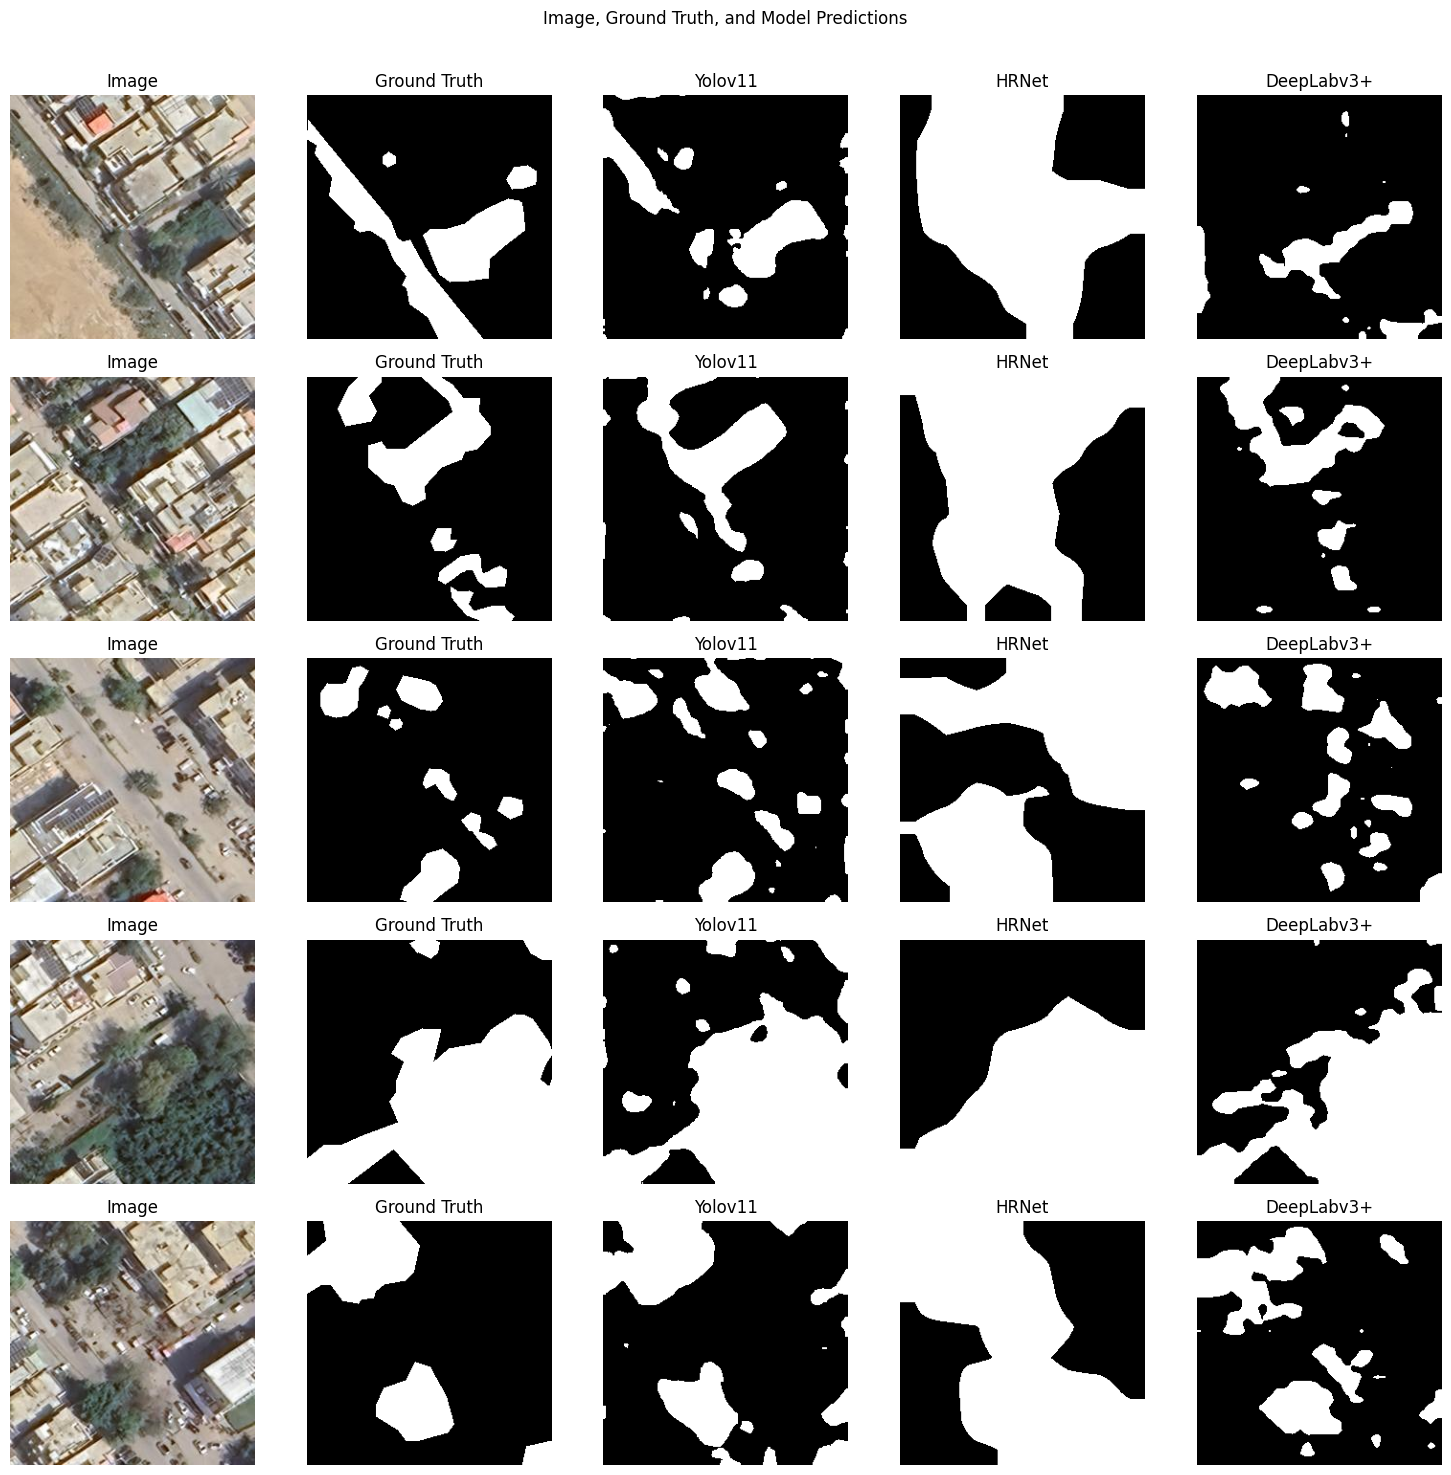

In [75]:
# Define the paths for the directories
images_folder = "Karachi_new/images"
ground_truth_folder = "Karachi_new/masks"  # Adjust if ground truth folder differs
deeplabv3_folder = "DeepLabv3+"
hrnet_folder = "HRNET"
yolov11_folder = "Yolov11"

# Define the output size for each image in the grid (adjust as needed)
IMG_SZ = (256, 256)

# Gather all images that are present in the images folder
image_files = sorted([f for f in os.listdir(images_folder) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])

# Number of images to display (adjust as needed)
num_images = min(len(image_files), 10)  # Display up to 10 images

# Initialize the plot
fig, axes = plt.subplots(num_images, 5, figsize=(15, num_images * 3))
fig.suptitle("Image, Ground Truth, and Model Predictions")

for idx, image_file in enumerate(image_files[:num_images]):
    # Load the original image
    image_path = os.path.join(images_folder, image_file)
    image = Image.open(image_path).convert("RGB").resize(IMG_SZ)

    # Load the ground truth mask
    gt_path = os.path.join(ground_truth_folder, fr"{image_file[0:-4]}_mask.png")
    print(gt_path)
    ground_truth = Image.open(gt_path).convert("L").resize(IMG_SZ) if os.path.exists(gt_path) else Image.new("L", IMG_SZ)

    # Load the DeepLabv3+ mask
    deeplabv3_path = os.path.join(deeplabv3_folder, os.path.splitext(image_file)[0] + '_mask.png')
    deeplabv3_mask = Image.open(deeplabv3_path).convert("L").resize(IMG_SZ) if os.path.exists(deeplabv3_path) else Image.new("L", IMG_SZ)

    # Load the HRNet mask
    hrnet_path = os.path.join(hrnet_folder, os.path.splitext(image_file)[0] + '_mask.png')
    hrnet_mask = Image.open(hrnet_path).convert("L").resize(IMG_SZ) if os.path.exists(hrnet_path) else Image.new("L", IMG_SZ)

    # Load the Yolov11 mask
    yolov11_path = os.path.join(yolov11_folder, os.path.splitext(image_file)[0] + '_mask.png')
    yolov11_mask = Image.open(yolov11_path).convert("L").resize(IMG_SZ) if os.path.exists(yolov11_path) else Image.new("L", IMG_SZ)

    # Plot the images in the respective row and columns
    axes[idx, 0].imshow(image)
    axes[idx, 0].set_title("Image")
    axes[idx, 1].imshow(ground_truth, cmap="gray")
    axes[idx, 1].set_title("Ground Truth")
    axes[idx, 2].imshow(yolov11_mask, cmap="gray")
    axes[idx, 2].set_title("Yolov11")
    axes[idx, 3].imshow(deeplabv3_mask, cmap="gray")
    axes[idx, 3].set_title("DeepLabv3+")
    axes[idx, 4].imshow(hrnet_mask, cmap="gray")
    axes[idx, 4].set_title("HRNet")

    # Turn off axis for each subplot
    for ax in axes[idx, :]:
        ax.axis("off")

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()